In [ ]:
!pip install -r "requirements.txt"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import statsmodels.api as sm

In [2]:
deaths = pyreadr.read_r("deaths.rds")[None]
deaths.head()

,yod,mod,dod,hod,cod
0,0,0,0,NaN,E14
1,0,0,0,NaN,E46
2,0,0,0,NaN,I21
3,0,0,0,NaN,K70
4,0,0,0,NaN,P21


In [3]:
#resultado ligeramente diferente, sospecho de un error en el paquete de R porque los indices de sus dataframes estan un poco raros
ok = deaths[(deaths["yod"]==2008) & (deaths["mod"] !=0) & (deaths["dod"] !=0)]
ok.iloc[[item*2000 for item in range(15)]]

,yod,mod,dod,hod,cod
11937,2008,1,1,1,B20
13937,2008,1,2,4,I67
15937,2008,1,3,8,I50
17937,2008,1,4,12,I67
19937,2008,1,5,16,K72
21937,2008,1,6,18,I21
23937,2008,1,7,20,I21
25937,2008,1,8,NaN,K74
27937,2008,1,10,5,K74
29937,2008,1,11,9,I21


In [4]:
codes = pd.read_csv("icd-main.csv").rename(columns={"code":"cod"})
codes = codes[~codes["cod"].duplicated()]
codes.head()

,cod,disease
0,A00,Cholera
1,A01,Typhoid and paratyphoid fevers
2,A02,Other salmonella infections
3,A03,Shigellosis
4,A04,Other bacterial intestinal infections


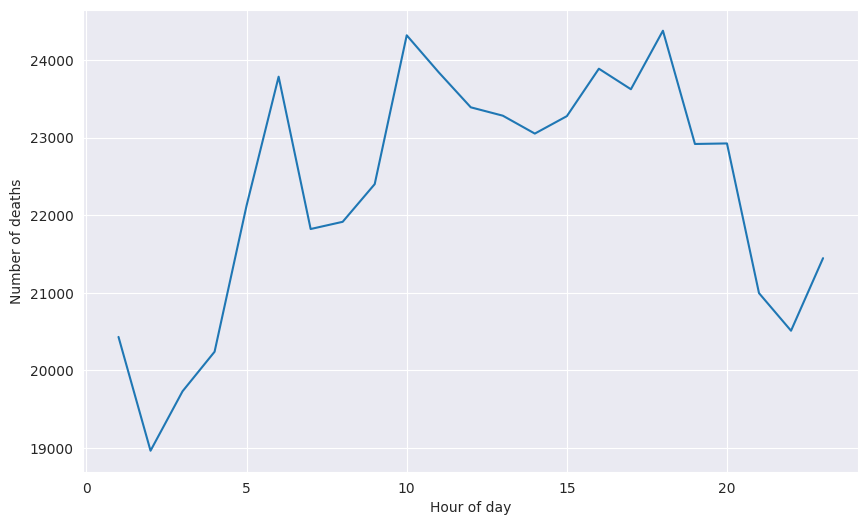

In [5]:
hod_all = deaths.groupby("hod")["hod"].count().reset_index(name='count')
sns.set_style("darkgrid")
fig = plt.figure(figsize=[10,6])
fig = sns.lineplot(hod_all,x="hod",y="count")
fig.set(xlabel="Hour of day", ylabel="Number of deaths")
fig.figure.figsize=[1,20]
fig.figure.savefig("overall.pdf")

In [6]:
hod2 =deaths.groupby(["cod","hod"])["hod"].count().reset_index(name="freq").merge(codes)
hod2["prop"]=hod2.groupby("cod")["freq"].transform(lambda x: x/sum(x))
hod2

,cod,hod,freq,disease,prop
0,A01,1,3,Typhoid and paratyphoid fevers,0.057692
1,A01,2,1,Typhoid and paratyphoid fevers,0.019231
2,A01,3,4,Typhoid and paratyphoid fevers,0.076923
3,A01,5,5,Typhoid and paratyphoid fevers,0.096154
4,A01,6,1,Typhoid and paratyphoid fevers,0.019231
...,...,...,...,...,...
15526,Y89,19,1,Sequelae of other external causes,0.027027
15527,Y89,20,2,Sequelae of other external causes,0.054054
15528,Y89,21,1,Sequelae of other external causes,0.027027
15529,Y89,22,1,Sequelae of other external causes,0.027027


In [7]:
overall = hod2.groupby("hod")["freq"].sum().reset_index(name="freq_all")
overall["prop_all"]=overall["freq_all"]/sum(overall["freq_all"])
hod2=overall.merge(hod2)
hod2.head()

,hod,freq_all,prop_all,cod,freq,disease,prop
0,1,20428,0.039815,A01,3,Typhoid and paratyphoid fevers,0.057692
1,1,20428,0.039815,A02,3,Other salmonella infections,0.048387
2,1,20428,0.039815,A04,7,Other bacterial intestinal infections,0.050360
3,1,20428,0.039815,A05,1,"Other bacterial foodborne intoxications, not e...",0.047619
4,1,20428,0.039815,A06,2,Amebiasis,0.023810


In [8]:
cods=deaths.groupby("cod")["cod"].count().reset_index(name="freq").sort_values("freq",ascending=False).merge(codes)

In [9]:
temp = cods[cods["freq"]>100].tail(30)
temp["disease"].apply(lambda x: x[0:30])
temp.head()

,cod,freq,disease
319,V04,119,Pedestrian injured in collision with heavy tra...
320,Q23,118,Congenital malformations of aortic and mitral ...
321,C51,117,Malignant neoplasm of vulva
322,P91,116,Other disturbances of cerebral status of newborn
323,X44,116,Accidental poisoning by and exposure to other ...


In [10]:
hod3 = hod2[(hod2["cod"].isin(["I21", "N18", "E84", "B16"])) & (hod2["hod"]>=8) & (hod2["hod"]<=12)][:15][["hod", "cod", "disease", "freq", "prop", "freq_all", "prop_all"]]
hod3

,hod,cod,disease,freq,prop,freq_all,prop_all
4629,8,B16,Acute hepatitis B,4,0.038095,21906,0.042696
4778,8,E84,Cystic fibrosis,3,0.029412,21906,0.042696
4843,8,I21,Acute myocardial infarction,2205,0.047121,21906,0.042696
5019,8,N18,Chronic renal failure,315,0.041241,21906,0.042696
5295,9,B16,Acute hepatitis B,7,0.066667,22388,0.043635
5463,9,E84,Cystic fibrosis,1,0.009804,22388,0.043635
5526,9,I21,Acute myocardial infarction,2209,0.047207,22388,0.043635
5697,9,N18,Chronic renal failure,333,0.043598,22388,0.043635
5983,10,B16,Acute hepatitis B,10,0.095238,24311,0.047383
6142,10,E84,Cystic fibrosis,7,0.068627,24311,0.047383


In [58]:
cod_n = hod2.groupby("cod")["freq"].sum().reset_index(name="n")
cod_dist =  hod2.groupby("cod")[["prop","prop_all"]].apply(lambda x: np.mean((x["prop"]-x["prop_all"])**2)).reset_index(name="dist")
devi = cod_n.merge(cod_dist)
devi=devi[devi["n"]>50]
devi

,cod,n,dist
0,A01,52,0.000892
1,A02,62,0.000738
3,A04,139,0.000198
5,A06,84,0.000440
8,A09,3056,0.000028
...,...,...,...
1169,Y33,55,0.000685
1170,Y34,749,0.000061
1180,Y57,107,0.000319
1186,Y83,171,0.000200


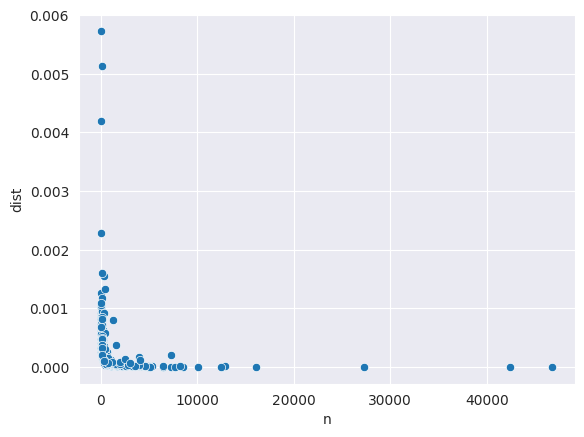

In [59]:
fig=plt.figure()
ax = plt.gca()
sns.scatterplot(data=devi,x="n",y="dist");

const   -3.646897
n       -0.897023
dtype: float64


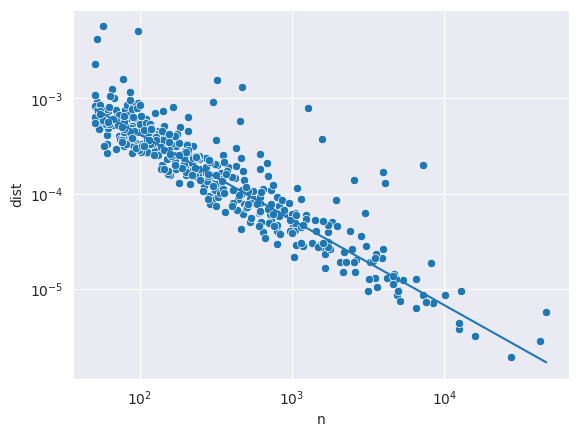

In [60]:
x_log=sm.add_constant(devi["n"].apply(np.log))
y_log=devi["dist"].apply(np.log)

model = sm.RLM(y_log, x_log, M=sm.robust.norms.HuberT())
model = model.fit()
print(model.params)

devi["dist_r1"]=np.exp(model.predict(x_log))

fig=plt.figure()
ax = plt.gca()
sns.scatterplot(devi,x="n",y="dist")
sns.lineplot(devi,x="n",y="dist_r1")
ax.set_yscale("log")
ax.set_xscale("log")


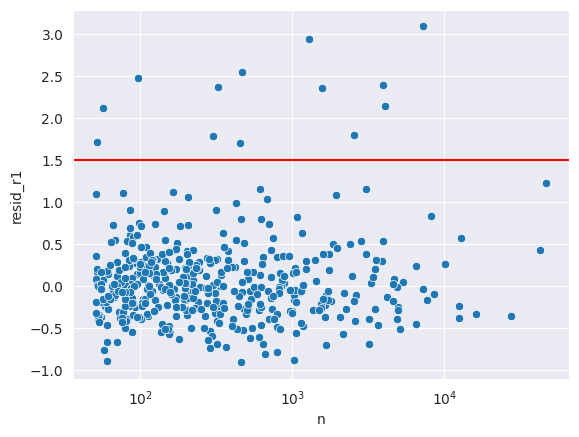

In [73]:
devi["resid_r1"] = np.log(devi["dist"])-np.log(devi["dist_r1"])
fig=plt.figure()
ax = plt.gca()
sns.scatterplot(devi,x="n",y="resid_r1")
ax.set_xscale("log")
plt.axhline(1.5,color="red");

In [93]:
# match_df en R se traduce a python como un merge() entre hod2 y unusual, ...
# manteniendo solo las columnas de hod2 y ordenando los valores de acuerdo a sus atributos desde el primer al ultimo
unusual = devi[devi["resid_r1"]>1.5] 
hod_unusual_big = hod2.merge(unusual[unusual["n"]>350])[hod2.columns].sort_values(hod2.columns.tolist())
hod_unusual_sml = hod2.merge(unusual[unusual["n"]<=350])[hod2.columns].sort_values(hod2.columns.tolist())

In [98]:
hod_unusual_big[["hod","prop","freq_all"]]

,hod,freq_all,prop_all,cod,freq,disease,prop
0,1,20428,0.039815,V09,148,Pedestrian injured in other and unspecified tr...,0.037412
23,1,20428,0.039815,V87,123,Traffic accident of specified type but victim'...,0.048330
46,1,20428,0.039815,V89,201,"Motor- or nonmotor-vehicle accident, type of v...",0.049495
69,1,20428,0.039815,W69,7,Drowning and submersion while in natural water,0.014925
92,1,20428,0.039815,W74,17,Unspecified drowning and submersion,0.013250
...,...,...,...,...,...,...,...
91,23,21438,0.041784,W69,8,Drowning and submersion while in natural water,0.017058
114,23,21438,0.041784,W74,31,Unspecified drowning and submersion,0.024162
137,23,21438,0.041784,W87,10,Exposure to unspecified electric current,0.021930
160,23,21438,0.041784,X95,513,Assault (homicide) by other and unspecified fi...,0.070974


In [109]:
hod_unusual_big[~hod_unusual_big["disease"].duplicated()]

,hod,freq_all,prop_all,cod,freq,disease,prop
0,1,20428,0.039815,V09,148,Pedestrian injured in other and unspecified tr...,0.037412
23,1,20428,0.039815,V87,123,Traffic accident of specified type but victim'...,0.048330
46,1,20428,0.039815,V89,201,"Motor- or nonmotor-vehicle accident, type of v...",0.049495
69,1,20428,0.039815,W69,7,Drowning and submersion while in natural water,0.014925
92,1,20428,0.039815,W74,17,Unspecified drowning and submersion,0.013250
115,1,20428,0.039815,W87,11,Exposure to unspecified electric current,0.024123
138,1,20428,0.039815,X95,436,Assault (homicide) by other and unspecified fi...,0.060321
161,1,20428,0.039815,X99,134,Assault (homicide) by sharp object,0.085079


In [110]:
hod_unusual_sml[~hod_unusual_sml["disease"].duplicated()]

,hod,freq_all,prop_all,cod,freq,disease,prop
0,1,20428,0.039815,R95,13,Sudden infant death syndrome,0.040248
23,1,20428,0.039815,W73,7,Other specified drowning and submersion,0.023102
46,2,18953,0.036940,V79,2,Bus occupant injured in other and unspecified ...,0.038462
64,2,18953,0.036940,X33,1,Victim of lightning,0.010309
79,9,22388,0.043635,V95,1,Accident to powered aircraft causing injury to...,0.017544
